# AI Comminuty @ Семинар №7
## Нейронки своими руками

### 0. Вспомним numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

%matplotlib inline

Выпишем при помощи NumPy все упомянутые в лекционной части функции.  
Важно: функции `sigmoid` и `log_loss` подправлены чтобы избежать переполнения.

In [3]:
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x, threshold=900):
    x = np.clip(x, -threshold, threshold)
    return 1 / (1 + np.exp(-x))

def log_loss(y_true, y_pred, eps=1e-16):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def log_loss_grad(y_true, y_pred):
    return y_pred - y_true

Создадим простую двухслойную нейронную сеть для классификации.  
У нее будет два скрытых слоя, после первого мы разместим ReLU, а после второго сигмоиду.  
Как функцию потерь выберем log-loss.

In [4]:
class TwoLayerFullyConnectedNNClassifier:
    """Implements a fully connected two layer neural network classifier in Numpy."""
    
    def __init__(self, w1, w2):
        ''' Arguments:
        weights : list of N arrays
        activations : list of N activation functions
        '''
        self.w1 = w1
        self.w2 = w2
        self.loss_history = []
        self.bias1 = 1
        self.bias2 = 1
    
    def forward(self, X):
        '''Forward pass of the neural network.'''
        h = relu(X @ self.w1 + self.bias1)
        y_pred = sigmoid(h @ self.w2 + self.bias2)
        return h, y_pred
    
    def fit(self, X, y, learning_rate=1e-5, max_iter=500):
        for t in range(max_iter):
            # Forward pass: compute predicted y
            h, y_pred = self.forward(X)

            # Compute and print loss
            loss = log_loss(y, y_pred)
            self.loss_history.append(loss.mean())

            # Backprop to compute gradients of w1 and w2 with respect to loss
            grad_y_pred = log_loss_grad(y, y_pred.reshape(-1))
            grad_y_pred *= (y_pred * (1 - y_pred)).reshape(-1)
            grad_y_pred = grad_y_pred.reshape(1, -1)
            
            grad_w2 = h.T @ grad_y_pred.T
            
            grad_h = np.outer(grad_y_pred, grad_w2)
            grad_h[h < 0] = 0
            
            grad_w1 = X.T @ grad_h

            # Update weights
            self.w1 -= learning_rate * grad_w1
            self.w2 -= learning_rate * grad_w2
            
    def predict_proba(self, X):
        h, y_pred = self.forward(X)
        return y_pred
    
    def predict(self, X, threshold=0.5):
        h, y_pred = self.forward(X)
        result = y_pred
        result[result > threshold] = 1
        result[result <= threshold] = 0
        return result.reshape(-1)

Создадим синтетическую выборку из двух классов, которую не разделить линейно.

In [5]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)

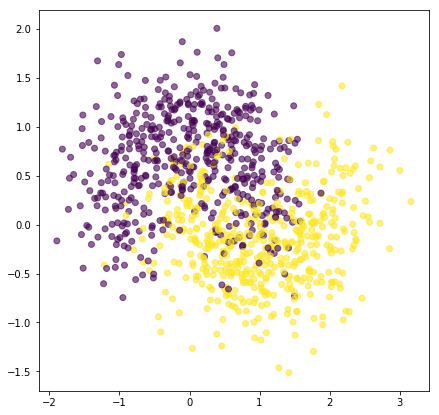

In [6]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6);

Отложим половину выборки для теста.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Начинаем!

In [8]:
np.random.seed(42)
nn = TwoLayerFullyConnectedNNClassifier(np.random.normal(scale=3, size=(2, 50)),
                                        np.random.normal(scale=2, size=(50, 1)))

При обучении постепенно уменьшим темп обучения.  Это скомпенсирует отсутствие адаптивности у метода оптимизации.

In [9]:
nn.fit(X_train, y_train, learning_rate=0.01, max_iter=400)
nn.fit(X_train, y_train, learning_rate=0.003, max_iter=100)
nn.fit(X_train, y_train, learning_rate=0.001, max_iter=100)

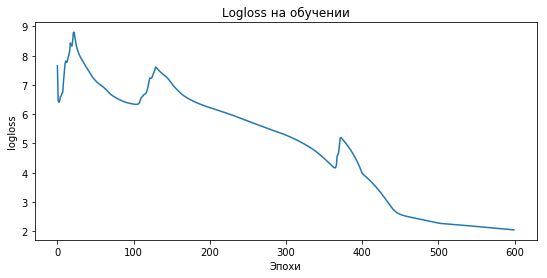

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Logloss на обучении')
plt.xlabel('Эпохи')
plt.ylabel('logloss')
plt.plot(nn.loss_history);

Посмотрим на ответ обученной модели:

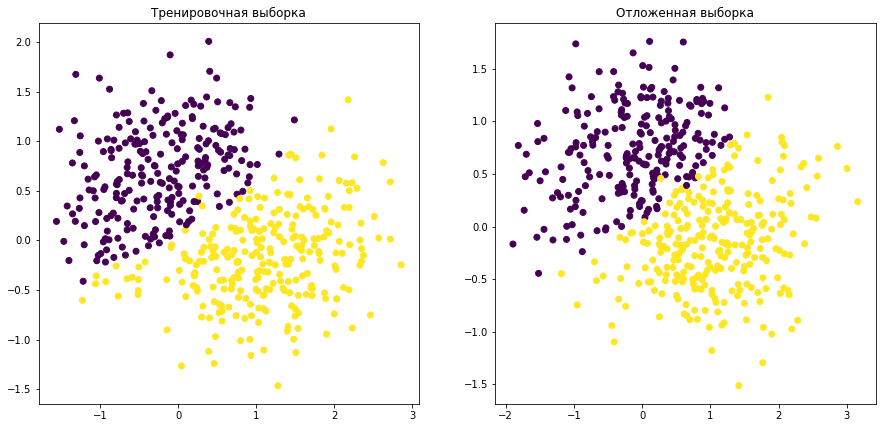

In [11]:
_, axes = plt.subplots(ncols=2, figsize=(15, 7));

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=nn.predict(X_train))
axes[0].set_title('Тренировочная выборка')

axes[1].scatter(X_test[:, 0], X_test[:, 1], c=nn.predict(X_test))
axes[1].set_title('Отложенная выборка');

In [12]:
f1_train, f1_test = f1_score(y_train, nn.predict(X_train)), f1_score(y_test, nn.predict(X_test))
print('f1 on train = {}, f1 on test = {}'.format(f1_train, f1_test))

f1 on train = 0.827852998065764, f1 on test = 0.8214971209213052


### 1. Потрогаем Keras

Мы долго думали, какой фреймворк использовать. Я решил выбрать Keras, потому что им пользуются исследователи ИИ.  
![](https://i.imgur.com/0x9Zkjt.jpg)

In [13]:
# Выберем карточку для вычислений на GPU.
# Важно для работы на общем сервере с >1 видеокартой.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
np.random.seed(23)  # for repeatability

from keras.models import Sequential
from keras.layers import Dense
from keras.activations import sigmoid, relu
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.initializers import normal

Using TensorFlow backend.


Переведем 1 к 1 двухслойную нейронку на Keras.

In [15]:
model = Sequential()
model.add(Dense(50, input_shape=(2,),
                kernel_initializer=normal(stddev=3),
                activation=relu))
model.add(Dense(50,
                kernel_initializer=normal(stddev=2),
                activation=sigmoid))
model.add(Dense(2))
model.compile(SGD(lr=0.01), loss=categorical_crossentropy)

Запустим процесс обучения.

In [16]:
history = model.fit(X_train, to_categorical(y_train), batch_size=1000, epochs=500, verbose=0)

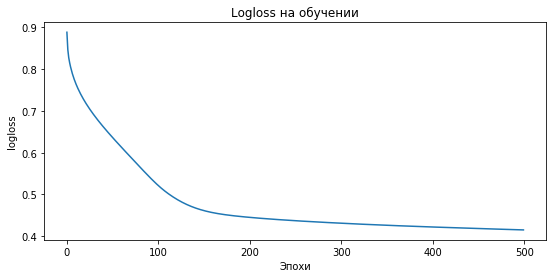

In [17]:
plt.figure(figsize=(9, 4))
plt.title('Logloss на обучении')
plt.xlabel('Эпохи')
plt.ylabel('logloss')
plt.plot(history.history['loss']);

 32/500 [>.............................] - ETA: 0s

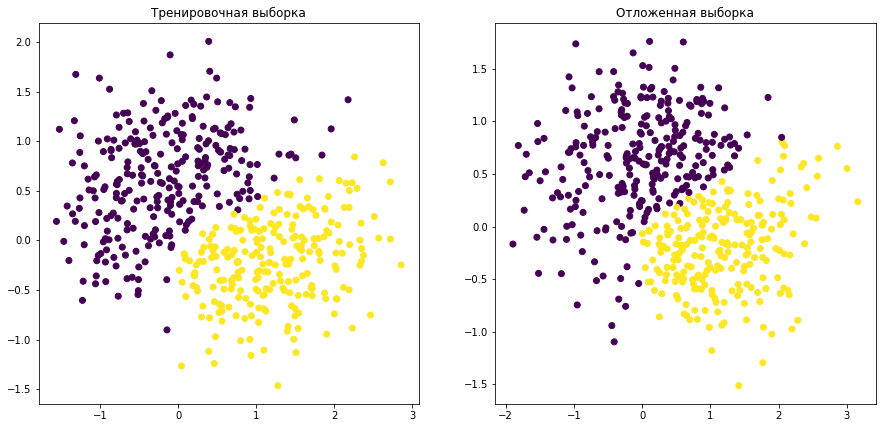

In [18]:
_, axes = plt.subplots(ncols=2, figsize=(15, 7));

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=model.predict_classes(X_train))
axes[0].set_title('Тренировочная выборка')

axes[1].scatter(X_test[:, 0], X_test[:, 1], c=model.predict_classes(X_test))
axes[1].set_title('Отложенная выборка');

In [19]:
f1_train = f1_score(y_train, model.predict_classes(X_train, verbose=0))
f1_test = f1_score(y_test, model.predict_classes(X_test, verbose=0))
print('f1 on train = {}, f1 on test = {}'.format(f1_train, f1_test))

f1 on train = 0.8247422680412372, f1 on test = 0.825


### 3.  Опять 25
Куда же без MNIST?

In [20]:
np.random.seed(23)

from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D, GaussianDropout, Input, Flatten
from keras.activations import softmax
from keras.optimizers import Nadam

from keras import backend as K

In [21]:
train, test = mnist.load_data()
X_train, y_train = train
X_test, y_test = test

Полюбуемся на цифры еще раз.

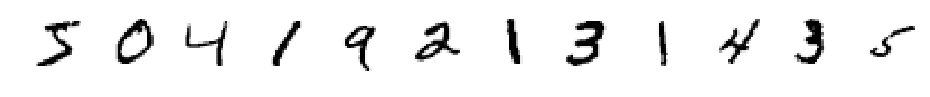

In [22]:
_, axes = plt.subplots(ncols=12, figsize=(16, 4))
for i, axis in enumerate(axes):
    axis.imshow(X_train[i], cmap=plt.cm.Greys)
    axis.axis('off')

In [23]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Создадим простенькую модель со сверточными слоями:

In [24]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), input_shape=input_shape, activation=relu))
model.add(GaussianDropout(rate=0.5))
model.add(MaxPool2D())
model.add(Flatten())

model.add(Dense(100, activation=relu))
model.add(Dense(20, activation=relu))

model.add(Dense(10, activation=softmax))

model.compile(Nadam(), loss=categorical_crossentropy)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               135300    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
Total para

In [26]:
history = model.fit(X_train, to_categorical(y_train), batch_size=128, epochs=10, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s - loss: 0.8640 - val_loss: 0.1316
Epoch 2/10
54000/54000 [==============================] - 4s - loss: 0.1575 - val_loss: 0.0913
Epoch 3/10
54000/54000 [==============================] - 4s - loss: 0.1053 - val_loss: 0.0799
Epoch 4/10
54000/54000 [==============================] - 4s - loss: 0.0791 - val_loss: 0.0666
Epoch 5/10
54000/54000 [==============================] - 4s - loss: 0.0648 - val_loss: 0.0653
Epoch 6/10
54000/54000 [==============================] - 4s - loss: 0.0562 - val_loss: 0.0705
Epoch 7/10
54000/54000 [==============================] - 4s - loss: 0.0486 - val_loss: 0.0614
Epoch 8/10
54000/54000 [==============================] - 4s - loss: 0.0461 - val_loss: 0.0585
Epoch 9/10
54000/54000 [==============================] - 4s - loss: 0.0406 - val_loss: 0.0671
Epoch 10/10
54000/54000 [==============================] - 4s - loss: 0.0377 - val_loss: 0.0608


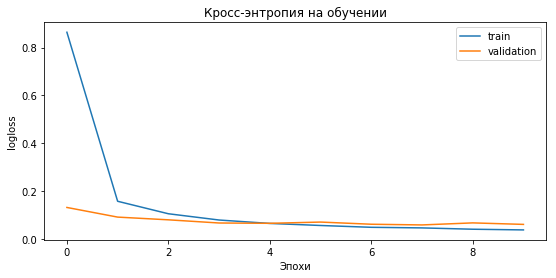

In [27]:
plt.figure(figsize=(9, 4))
plt.title('Кросс-энтропия на обучении')
plt.xlabel('Эпохи')
plt.ylabel('logloss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [28]:
f1_train = f1_score(y_train, model.predict_classes(X_train, verbose=1), average='macro')
f1_test = f1_score(y_test, model.predict_classes(X_test, verbose=1), average='macro')
print()
print('f1 on train = {}, f1 on test = {}'.format(f1_train, f1_test))

 9600/10000 [===========================>..] - ETA: 0s
f1 on train = 0.9937745875153873, f1 on test = 0.9801761072409226
